In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import torch
import pandas as pd
from tqdm import tqdm
from torchsummary import summary

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [10]:
import os
os.chdir(os.getcwd().replace('/notebooks', ''))

In [11]:
df = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
data_array = df.values
data_tensor = torch.tensor(data_array, dtype=torch.float32)

print(data_tensor.shape)

torch.Size([1460, 77])


In [12]:
features = torch.tensor(df.iloc[:, :-2].values, dtype=torch.float32)  # Tất cả cột trừ cột cuối
labels = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)  # Cột cuối cùng

print(features.shape, labels.shape)  # Kiểm tra kích thước tensor

torch.Size([1460, 75]) torch.Size([1460, 1])


In [13]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=75):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),          # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),           # Layer 3
            nn.ReLU(),
            nn.Linear(32, 1)             # Output layer
        )

    def forward(self, x):
        return self.model(x)

In [14]:
# Kích thước batch
batch_size = 32  

# Chia tập train (80%) và validation (20%)
train_size = int(0.8 * len(features))
val_size = len(features) - train_size

# Chia dataset thật thành train và validation
train_dataset, val_dataset = random_split(TensorDataset(features, labels), [train_size, val_size])

# Tạo DataLoader cho train và validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra một batch train
for batch_features, batch_labels in train_loader:
    print("Train Batch Shape:", batch_features.shape, batch_labels.shape)
    break  # Chỉ in thử batch đầu tiên

# Kiểm tra một batch validation
for batch_features, batch_labels in test_loader:
    print("Validation Batch Shape:", batch_features.shape, batch_labels.shape)
    break  # Chỉ in thử batch đầu tiên

Train Batch Shape: torch.Size([32, 75]) torch.Size([32, 1])
Validation Batch Shape: torch.Size([32, 75]) torch.Size([32, 1])


In [15]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    num_batches = 0  # Đếm số batch
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            num_batches += 1  # Cập nhật số batch

    # Trả về loss trung bình thay vì tổng loss
    return test_loss / num_batches if num_batches > 0 else float('inf')

In [16]:
# Khởi tạo mô hình và chuyển lên device
model = MLP()
summary(model, input_size = (75,))
model.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           9,728
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 1]              33
Total params: 20,097
Trainable params: 20,097
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
---------------------------------------------

In [17]:
# Danh sách lưu loss
train_losses = []
test_losses = []
batch_losses = []  # Lưu loss theo từng batch để minh họa chi tiết hơn

max_epoch = 200

# Training loop
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    batch_loss_list = []  # Lưu loss của từng batch trong epoch

    for i, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}")):
        # Chuyển dữ liệu lên device
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()  # Fix lỗi thiếu dấu ()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_loss_list.append(loss.item())  # Ghi lại loss từng batch

    # Tính trung bình loss trên tập train
    epoch_loss = running_loss / (i + 1)
    train_losses.append(epoch_loss)
    batch_losses.append(batch_loss_list)  # Ghi lại loss từng batch theo epoch

    # Đánh giá trên tập test
    model.eval()
    test_loss = evaluate(model, test_loader, criterion)
    scheduler.step(test_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{max_epoch} - Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/200: 100%|██████████| 37/37 [00:00<00:00, 224.81it/s]


Epoch 1/200 - Train Loss: 15.9869, Test Loss: 6.1925


Epoch 2/200: 100%|██████████| 37/37 [00:00<00:00, 218.02it/s]

Epoch 2/200 - Train Loss: 8.1974, Test Loss: 1.7057

Epoch 3/200: 100%|██████████| 37/37 [00:00<00:00, 214.72it/s]

Epoch 3/200 - Train Loss: 5.6695, Test Loss: 1.2777



Epoch 4/200: 100%|██████████| 37/37 [00:00<00:00, 225.37it/s]


Epoch 4/200 - Train Loss: 4.5755, Test Loss: 1.2267


Epoch 5/200: 100%|██████████| 37/37 [00:00<00:00, 215.01it/s]


Epoch 5/200 - Train Loss: 4.0672, Test Loss: 1.1983


Epoch 6/200: 100%|██████████| 37/37 [00:00<00:00, 183.75it/s]


Epoch 6/200 - Train Loss: 3.1615, Test Loss: 1.0483


Epoch 7/200: 100%|██████████| 37/37 [00:00<00:00, 173.16it/s]


Epoch 7/200 - Train Loss: 3.0771, Test Loss: 0.9638


Epoch 8/200: 100%|██████████| 37/37 [00:00<00:00, 191.01it/s]


Epoch 8/200 - Train Loss: 2.7476, Test Loss: 0.9316


Epoch 9/200: 100%|██████████| 37/37 [00:00<00:00, 276.14it/s]


Epoch 9/200 - Train Loss: 2.4322, Test Loss: 0.9245


Epoch 10/200: 100%|██████████| 37/37 [00:00<00:00, 205.26it/s]


Epoch 10/200 - Train Loss: 2.1514, Test Loss: 0.9256


Epoch 11/200: 100%|██████████| 37/37 [00:00<00:00, 272.55it/s]


Epoch 11/200 - Train Loss: 2.1375, Test Loss: 0.9422


Epoch 12/200: 100%|██████████| 37/37 [00:00<00:00, 220.42it/s]


Epoch 12/200 - Train Loss: 1.9883, Test Loss: 0.9290


Epoch 13/200: 100%|██████████| 37/37 [00:00<00:00, 195.98it/s]


Epoch 13/200 - Train Loss: 1.8890, Test Loss: 0.9253


Epoch 14/200: 100%|██████████| 37/37 [00:00<00:00, 227.61it/s]


Epoch 14/200 - Train Loss: 1.9198, Test Loss: 0.9372


Epoch 15/200: 100%|██████████| 37/37 [00:00<00:00, 234.92it/s]


Epoch 15/200 - Train Loss: 1.6598, Test Loss: 0.9538


Epoch 16/200: 100%|██████████| 37/37 [00:00<00:00, 212.01it/s]


Epoch 16/200 - Train Loss: 1.6302, Test Loss: 0.9666


Epoch 17/200: 100%|██████████| 37/37 [00:00<00:00, 243.51it/s]


Epoch 17/200 - Train Loss: 1.7876, Test Loss: 0.9753


Epoch 18/200: 100%|██████████| 37/37 [00:00<00:00, 228.62it/s]


Epoch 18/200 - Train Loss: 1.5905, Test Loss: 0.9708


Epoch 19/200: 100%|██████████| 37/37 [00:00<00:00, 224.65it/s]


Epoch 19/200 - Train Loss: 1.5069, Test Loss: 0.9697


Epoch 20/200: 100%|██████████| 37/37 [00:00<00:00, 232.66it/s]


Epoch 20/200 - Train Loss: 1.7306, Test Loss: 0.9642


Epoch 21/200: 100%|██████████| 37/37 [00:00<00:00, 190.93it/s]


Epoch 21/200 - Train Loss: 1.5973, Test Loss: 0.9515


Epoch 22/200: 100%|██████████| 37/37 [00:00<00:00, 270.19it/s]


Epoch 22/200 - Train Loss: 1.5758, Test Loss: 0.9554


Epoch 23/200: 100%|██████████| 37/37 [00:00<00:00, 217.20it/s]


Epoch 23/200 - Train Loss: 1.5317, Test Loss: 0.9573


Epoch 24/200: 100%|██████████| 37/37 [00:00<00:00, 226.19it/s]


Epoch 24/200 - Train Loss: 1.5180, Test Loss: 0.9526


Epoch 25/200: 100%|██████████| 37/37 [00:00<00:00, 238.71it/s]


Epoch 25/200 - Train Loss: 1.4929, Test Loss: 0.9457


Epoch 26/200: 100%|██████████| 37/37 [00:00<00:00, 216.54it/s]


Epoch 26/200 - Train Loss: 1.4366, Test Loss: 0.9440


Epoch 27/200: 100%|██████████| 37/37 [00:00<00:00, 254.56it/s]


Epoch 27/200 - Train Loss: 1.4664, Test Loss: 0.9470


Epoch 28/200: 100%|██████████| 37/37 [00:00<00:00, 181.73it/s]


Epoch 28/200 - Train Loss: 1.5256, Test Loss: 0.9455


Epoch 29/200: 100%|██████████| 37/37 [00:00<00:00, 247.24it/s]


Epoch 29/200 - Train Loss: 1.5640, Test Loss: 0.9443


Epoch 30/200: 100%|██████████| 37/37 [00:00<00:00, 211.52it/s]


Epoch 30/200 - Train Loss: 1.3688, Test Loss: 0.9426


Epoch 31/200: 100%|██████████| 37/37 [00:00<00:00, 232.36it/s]


Epoch 31/200 - Train Loss: 1.4891, Test Loss: 0.9423


Epoch 32/200: 100%|██████████| 37/37 [00:00<00:00, 212.25it/s]


Epoch 32/200 - Train Loss: 1.5624, Test Loss: 0.9422


Epoch 33/200: 100%|██████████| 37/37 [00:00<00:00, 184.63it/s]


Epoch 33/200 - Train Loss: 1.4436, Test Loss: 0.9442


Epoch 34/200: 100%|██████████| 37/37 [00:00<00:00, 227.63it/s]


Epoch 34/200 - Train Loss: 1.4349, Test Loss: 0.9449


Epoch 35/200: 100%|██████████| 37/37 [00:00<00:00, 178.87it/s]


Epoch 35/200 - Train Loss: 1.4205, Test Loss: 0.9436


Epoch 36/200: 100%|██████████| 37/37 [00:00<00:00, 200.57it/s]


Epoch 36/200 - Train Loss: 1.5151, Test Loss: 0.9436


Epoch 37/200: 100%|██████████| 37/37 [00:00<00:00, 214.68it/s]


Epoch 37/200 - Train Loss: 1.4073, Test Loss: 0.9428


Epoch 38/200: 100%|██████████| 37/37 [00:00<00:00, 189.01it/s]


Epoch 38/200 - Train Loss: 1.3128, Test Loss: 0.9423


Epoch 39/200: 100%|██████████| 37/37 [00:00<00:00, 185.69it/s]


Epoch 39/200 - Train Loss: 1.3257, Test Loss: 0.9424


Epoch 40/200: 100%|██████████| 37/37 [00:00<00:00, 241.18it/s]


Epoch 40/200 - Train Loss: 1.3955, Test Loss: 0.9421


Epoch 41/200: 100%|██████████| 37/37 [00:00<00:00, 203.50it/s]


Epoch 41/200 - Train Loss: 1.4866, Test Loss: 0.9422


Epoch 42/200: 100%|██████████| 37/37 [00:00<00:00, 194.77it/s]


Epoch 42/200 - Train Loss: 1.4338, Test Loss: 0.9423


Epoch 43/200: 100%|██████████| 37/37 [00:00<00:00, 204.73it/s]


Epoch 43/200 - Train Loss: 1.3828, Test Loss: 0.9423


Epoch 44/200: 100%|██████████| 37/37 [00:00<00:00, 217.14it/s]


Epoch 44/200 - Train Loss: 1.4372, Test Loss: 0.9424


Epoch 45/200: 100%|██████████| 37/37 [00:00<00:00, 231.69it/s]


Epoch 45/200 - Train Loss: 1.4361, Test Loss: 0.9415


Epoch 46/200: 100%|██████████| 37/37 [00:00<00:00, 257.19it/s]


Epoch 46/200 - Train Loss: 1.3362, Test Loss: 0.9417


Epoch 47/200: 100%|██████████| 37/37 [00:00<00:00, 237.91it/s]


Epoch 47/200 - Train Loss: 1.4412, Test Loss: 0.9419


Epoch 48/200: 100%|██████████| 37/37 [00:00<00:00, 169.05it/s]


Epoch 48/200 - Train Loss: 1.3831, Test Loss: 0.9422


Epoch 49/200: 100%|██████████| 37/37 [00:00<00:00, 166.56it/s]


Epoch 49/200 - Train Loss: 1.4240, Test Loss: 0.9420


Epoch 50/200: 100%|██████████| 37/37 [00:00<00:00, 224.62it/s]

Epoch 50/200 - Train Loss: 1.3496, Test Loss: 0.9419

Epoch 51/200: 100%|██████████| 37/37 [00:00<00:00, 160.88it/s]


Epoch 51/200 - Train Loss: 1.4045, Test Loss: 0.9418


Epoch 52/200: 100%|██████████| 37/37 [00:00<00:00, 208.47it/s]


Epoch 52/200 - Train Loss: 1.4726, Test Loss: 0.9418


Epoch 53/200: 100%|██████████| 37/37 [00:00<00:00, 228.65it/s]


Epoch 53/200 - Train Loss: 1.4691, Test Loss: 0.9419


Epoch 54/200: 100%|██████████| 37/37 [00:00<00:00, 222.98it/s]


Epoch 54/200 - Train Loss: 1.3510, Test Loss: 0.9419


Epoch 55/200: 100%|██████████| 37/37 [00:00<00:00, 217.98it/s]

Epoch 55/200 - Train Loss: 1.3653, Test Loss: 0.9420

Epoch 56/200: 100%|██████████| 37/37 [00:00<00:00, 187.27it/s]


Epoch 56/200 - Train Loss: 1.4127, Test Loss: 0.9422


Epoch 57/200: 100%|██████████| 37/37 [00:00<00:00, 206.61it/s]


Epoch 57/200 - Train Loss: 1.4562, Test Loss: 0.9422


Epoch 58/200: 100%|██████████| 37/37 [00:00<00:00, 222.89it/s]


Epoch 58/200 - Train Loss: 1.4323, Test Loss: 0.9421


Epoch 59/200: 100%|██████████| 37/37 [00:00<00:00, 214.99it/s]


Epoch 59/200 - Train Loss: 1.3937, Test Loss: 0.9421


Epoch 60/200: 100%|██████████| 37/37 [00:00<00:00, 214.35it/s]


Epoch 60/200 - Train Loss: 1.4030, Test Loss: 0.9421


Epoch 61/200: 100%|██████████| 37/37 [00:00<00:00, 214.52it/s]


Epoch 61/200 - Train Loss: 1.3834, Test Loss: 0.9421


Epoch 62/200: 100%|██████████| 37/37 [00:00<00:00, 218.03it/s]


Epoch 62/200 - Train Loss: 1.3234, Test Loss: 0.9422


Epoch 63/200: 100%|██████████| 37/37 [00:00<00:00, 217.66it/s]

Epoch 63/200 - Train Loss: 1.3689, Test Loss: 0.9422

Epoch 64/200: 100%|██████████| 37/37 [00:00<00:00, 172.77it/s]


Epoch 64/200 - Train Loss: 1.3581, Test Loss: 0.9423


Epoch 65/200: 100%|██████████| 37/37 [00:00<00:00, 238.00it/s]


Epoch 65/200 - Train Loss: 1.3686, Test Loss: 0.9423


Epoch 66/200: 100%|██████████| 37/37 [00:00<00:00, 225.85it/s]


Epoch 66/200 - Train Loss: 1.4209, Test Loss: 0.9423


Epoch 67/200: 100%|██████████| 37/37 [00:00<00:00, 277.66it/s]


Epoch 67/200 - Train Loss: 1.3585, Test Loss: 0.9423


Epoch 68/200: 100%|██████████| 37/37 [00:00<00:00, 271.94it/s]


Epoch 68/200 - Train Loss: 1.2867, Test Loss: 0.9423


Epoch 69/200: 100%|██████████| 37/37 [00:00<00:00, 229.40it/s]


Epoch 69/200 - Train Loss: 1.3502, Test Loss: 0.9423


Epoch 70/200: 100%|██████████| 37/37 [00:00<00:00, 268.82it/s]


Epoch 70/200 - Train Loss: 1.3787, Test Loss: 0.9423


Epoch 71/200: 100%|██████████| 37/37 [00:00<00:00, 265.20it/s]


Epoch 71/200 - Train Loss: 1.4379, Test Loss: 0.9423


Epoch 72/200: 100%|██████████| 37/37 [00:00<00:00, 273.31it/s]


Epoch 72/200 - Train Loss: 1.4457, Test Loss: 0.9423


Epoch 73/200: 100%|██████████| 37/37 [00:00<00:00, 231.42it/s]


Epoch 73/200 - Train Loss: 1.4048, Test Loss: 0.9423


Epoch 74/200: 100%|██████████| 37/37 [00:00<00:00, 229.74it/s]


Epoch 74/200 - Train Loss: 1.3902, Test Loss: 0.9423


Epoch 75/200: 100%|██████████| 37/37 [00:00<00:00, 266.13it/s]


Epoch 75/200 - Train Loss: 1.3535, Test Loss: 0.9423


Epoch 76/200: 100%|██████████| 37/37 [00:00<00:00, 283.23it/s]


Epoch 76/200 - Train Loss: 1.3290, Test Loss: 0.9423


Epoch 77/200: 100%|██████████| 37/37 [00:00<00:00, 265.48it/s]


Epoch 77/200 - Train Loss: 1.4317, Test Loss: 0.9423


Epoch 78/200: 100%|██████████| 37/37 [00:00<00:00, 227.16it/s]


Epoch 78/200 - Train Loss: 1.4425, Test Loss: 0.9423


Epoch 79/200: 100%|██████████| 37/37 [00:00<00:00, 232.63it/s]


Epoch 79/200 - Train Loss: 1.3269, Test Loss: 0.9423


Epoch 80/200: 100%|██████████| 37/37 [00:00<00:00, 261.37it/s]


Epoch 80/200 - Train Loss: 1.3256, Test Loss: 0.9423


Epoch 81/200: 100%|██████████| 37/37 [00:00<00:00, 246.65it/s]


Epoch 81/200 - Train Loss: 1.3977, Test Loss: 0.9423


Epoch 82/200: 100%|██████████| 37/37 [00:00<00:00, 234.15it/s]


Epoch 82/200 - Train Loss: 1.3705, Test Loss: 0.9423


Epoch 83/200: 100%|██████████| 37/37 [00:00<00:00, 284.16it/s]


Epoch 83/200 - Train Loss: 1.4183, Test Loss: 0.9423


Epoch 84/200: 100%|██████████| 37/37 [00:00<00:00, 277.30it/s]


Epoch 84/200 - Train Loss: 1.4057, Test Loss: 0.9423


Epoch 85/200: 100%|██████████| 37/37 [00:00<00:00, 261.39it/s]


Epoch 85/200 - Train Loss: 1.3180, Test Loss: 0.9423


Epoch 86/200: 100%|██████████| 37/37 [00:00<00:00, 274.57it/s]


Epoch 86/200 - Train Loss: 1.4801, Test Loss: 0.9423


Epoch 87/200: 100%|██████████| 37/37 [00:00<00:00, 264.19it/s]


Epoch 87/200 - Train Loss: 1.3472, Test Loss: 0.9423


Epoch 88/200: 100%|██████████| 37/37 [00:00<00:00, 264.89it/s]


Epoch 88/200 - Train Loss: 1.3976, Test Loss: 0.9423


Epoch 89/200: 100%|██████████| 37/37 [00:00<00:00, 292.23it/s]


Epoch 89/200 - Train Loss: 1.4387, Test Loss: 0.9423


Epoch 90/200: 100%|██████████| 37/37 [00:00<00:00, 288.06it/s]


Epoch 90/200 - Train Loss: 1.4252, Test Loss: 0.9423


Epoch 91/200: 100%|██████████| 37/37 [00:00<00:00, 185.02it/s]


Epoch 91/200 - Train Loss: 1.3675, Test Loss: 0.9423


Epoch 92/200: 100%|██████████| 37/37 [00:00<00:00, 224.20it/s]


Epoch 92/200 - Train Loss: 1.4023, Test Loss: 0.9423


Epoch 93/200: 100%|██████████| 37/37 [00:00<00:00, 169.06it/s]


Epoch 93/200 - Train Loss: 1.2857, Test Loss: 0.9423


Epoch 94/200: 100%|██████████| 37/37 [00:00<00:00, 240.65it/s]


Epoch 94/200 - Train Loss: 1.4199, Test Loss: 0.9423


Epoch 95/200: 100%|██████████| 37/37 [00:00<00:00, 228.53it/s]


Epoch 95/200 - Train Loss: 1.4029, Test Loss: 0.9423


Epoch 96/200: 100%|██████████| 37/37 [00:00<00:00, 223.55it/s]


Epoch 96/200 - Train Loss: 1.3627, Test Loss: 0.9423


Epoch 97/200: 100%|██████████| 37/37 [00:00<00:00, 204.66it/s]


Epoch 97/200 - Train Loss: 1.3160, Test Loss: 0.9423


Epoch 98/200: 100%|██████████| 37/37 [00:00<00:00, 261.05it/s]


Epoch 98/200 - Train Loss: 1.4452, Test Loss: 0.9423


Epoch 99/200: 100%|██████████| 37/37 [00:00<00:00, 254.17it/s]


Epoch 99/200 - Train Loss: 1.3815, Test Loss: 0.9423


Epoch 100/200: 100%|██████████| 37/37 [00:00<00:00, 173.99it/s]


Epoch 100/200 - Train Loss: 1.4316, Test Loss: 0.9423


Epoch 101/200: 100%|██████████| 37/37 [00:00<00:00, 236.07it/s]


Epoch 101/200 - Train Loss: 1.3832, Test Loss: 0.9423


Epoch 102/200: 100%|██████████| 37/37 [00:00<00:00, 238.30it/s]


Epoch 102/200 - Train Loss: 1.4462, Test Loss: 0.9423


Epoch 103/200: 100%|██████████| 37/37 [00:00<00:00, 209.64it/s]


Epoch 103/200 - Train Loss: 1.3737, Test Loss: 0.9423


Epoch 104/200: 100%|██████████| 37/37 [00:00<00:00, 153.16it/s]


Epoch 104/200 - Train Loss: 1.3863, Test Loss: 0.9423


Epoch 105/200: 100%|██████████| 37/37 [00:00<00:00, 182.34it/s]


Epoch 105/200 - Train Loss: 1.4006, Test Loss: 0.9423


Epoch 106/200: 100%|██████████| 37/37 [00:00<00:00, 194.23it/s]


Epoch 106/200 - Train Loss: 1.2853, Test Loss: 0.9423


Epoch 107/200: 100%|██████████| 37/37 [00:00<00:00, 210.58it/s]


Epoch 107/200 - Train Loss: 1.3537, Test Loss: 0.9423


Epoch 108/200: 100%|██████████| 37/37 [00:00<00:00, 212.76it/s]


Epoch 108/200 - Train Loss: 1.4316, Test Loss: 0.9423


Epoch 109/200: 100%|██████████| 37/37 [00:00<00:00, 216.97it/s]


Epoch 109/200 - Train Loss: 1.4169, Test Loss: 0.9423


Epoch 110/200: 100%|██████████| 37/37 [00:00<00:00, 173.44it/s]


Epoch 110/200 - Train Loss: 1.3705, Test Loss: 0.9423


Epoch 111/200: 100%|██████████| 37/37 [00:00<00:00, 231.08it/s]


Epoch 111/200 - Train Loss: 1.3977, Test Loss: 0.9423


Epoch 112/200: 100%|██████████| 37/37 [00:00<00:00, 223.21it/s]


Epoch 112/200 - Train Loss: 1.3804, Test Loss: 0.9423


Epoch 113/200: 100%|██████████| 37/37 [00:00<00:00, 202.22it/s]


Epoch 113/200 - Train Loss: 1.3583, Test Loss: 0.9423


Epoch 114/200: 100%|██████████| 37/37 [00:00<00:00, 189.76it/s]


Epoch 114/200 - Train Loss: 1.4521, Test Loss: 0.9423


Epoch 115/200: 100%|██████████| 37/37 [00:00<00:00, 214.16it/s]


Epoch 115/200 - Train Loss: 1.4156, Test Loss: 0.9423


Epoch 116/200: 100%|██████████| 37/37 [00:00<00:00, 174.15it/s]


Epoch 116/200 - Train Loss: 1.4510, Test Loss: 0.9423


Epoch 117/200: 100%|██████████| 37/37 [00:00<00:00, 192.18it/s]


Epoch 117/200 - Train Loss: 1.3829, Test Loss: 0.9423


Epoch 118/200: 100%|██████████| 37/37 [00:00<00:00, 203.12it/s]


Epoch 118/200 - Train Loss: 1.3665, Test Loss: 0.9423


Epoch 119/200: 100%|██████████| 37/37 [00:00<00:00, 181.80it/s]


Epoch 119/200 - Train Loss: 1.3979, Test Loss: 0.9423


Epoch 120/200: 100%|██████████| 37/37 [00:00<00:00, 247.71it/s]


Epoch 120/200 - Train Loss: 1.4495, Test Loss: 0.9423


Epoch 121/200: 100%|██████████| 37/37 [00:00<00:00, 215.19it/s]

Epoch 121/200 - Train Loss: 1.3309, Test Loss: 0.9423

Epoch 122/200: 100%|██████████| 37/37 [00:00<00:00, 236.89it/s]


Epoch 122/200 - Train Loss: 1.3119, Test Loss: 0.9423


Epoch 123/200: 100%|██████████| 37/37 [00:00<00:00, 190.37it/s]


Epoch 123/200 - Train Loss: 1.4175, Test Loss: 0.9423


Epoch 124/200: 100%|██████████| 37/37 [00:00<00:00, 201.41it/s]


Epoch 124/200 - Train Loss: 1.3960, Test Loss: 0.9423


Epoch 125/200: 100%|██████████| 37/37 [00:00<00:00, 223.35it/s]


Epoch 125/200 - Train Loss: 1.3279, Test Loss: 0.9423


Epoch 126/200: 100%|██████████| 37/37 [00:00<00:00, 246.45it/s]


Epoch 126/200 - Train Loss: 1.4412, Test Loss: 0.9423


Epoch 127/200: 100%|██████████| 37/37 [00:00<00:00, 203.60it/s]


Epoch 127/200 - Train Loss: 1.3263, Test Loss: 0.9423


Epoch 128/200: 100%|██████████| 37/37 [00:00<00:00, 194.10it/s]


Epoch 128/200 - Train Loss: 1.3612, Test Loss: 0.9423


Epoch 129/200: 100%|██████████| 37/37 [00:00<00:00, 217.83it/s]


Epoch 129/200 - Train Loss: 1.4926, Test Loss: 0.9423


Epoch 130/200: 100%|██████████| 37/37 [00:00<00:00, 241.20it/s]


Epoch 130/200 - Train Loss: 1.3789, Test Loss: 0.9423


Epoch 131/200: 100%|██████████| 37/37 [00:00<00:00, 253.71it/s]


Epoch 131/200 - Train Loss: 1.3404, Test Loss: 0.9423


Epoch 132/200: 100%|██████████| 37/37 [00:00<00:00, 218.14it/s]


Epoch 132/200 - Train Loss: 1.4808, Test Loss: 0.9423


Epoch 133/200: 100%|██████████| 37/37 [00:00<00:00, 233.42it/s]


Epoch 133/200 - Train Loss: 1.3897, Test Loss: 0.9423


Epoch 134/200: 100%|██████████| 37/37 [00:00<00:00, 250.20it/s]


Epoch 134/200 - Train Loss: 1.4514, Test Loss: 0.9423


Epoch 135/200: 100%|██████████| 37/37 [00:00<00:00, 217.38it/s]


Epoch 135/200 - Train Loss: 1.3557, Test Loss: 0.9423


Epoch 136/200: 100%|██████████| 37/37 [00:00<00:00, 255.22it/s]


Epoch 136/200 - Train Loss: 1.3838, Test Loss: 0.9423


Epoch 137/200: 100%|██████████| 37/37 [00:00<00:00, 197.82it/s]


Epoch 137/200 - Train Loss: 1.3970, Test Loss: 0.9423


Epoch 138/200: 100%|██████████| 37/37 [00:00<00:00, 213.90it/s]


Epoch 138/200 - Train Loss: 1.3823, Test Loss: 0.9423


Epoch 139/200: 100%|██████████| 37/37 [00:00<00:00, 243.56it/s]


Epoch 139/200 - Train Loss: 1.3967, Test Loss: 0.9423


Epoch 140/200: 100%|██████████| 37/37 [00:00<00:00, 203.14it/s]


Epoch 140/200 - Train Loss: 1.4192, Test Loss: 0.9423


Epoch 141/200: 100%|██████████| 37/37 [00:00<00:00, 228.90it/s]


Epoch 141/200 - Train Loss: 1.4623, Test Loss: 0.9423


Epoch 142/200: 100%|██████████| 37/37 [00:00<00:00, 156.64it/s]


Epoch 142/200 - Train Loss: 1.4011, Test Loss: 0.9423


Epoch 143/200: 100%|██████████| 37/37 [00:00<00:00, 211.34it/s]


Epoch 143/200 - Train Loss: 1.3536, Test Loss: 0.9424


Epoch 144/200: 100%|██████████| 37/37 [00:00<00:00, 241.91it/s]


Epoch 144/200 - Train Loss: 1.3586, Test Loss: 0.9424


Epoch 145/200: 100%|██████████| 37/37 [00:00<00:00, 239.92it/s]


Epoch 145/200 - Train Loss: 1.3687, Test Loss: 0.9424


Epoch 146/200: 100%|██████████| 37/37 [00:00<00:00, 185.43it/s]


Epoch 146/200 - Train Loss: 1.3864, Test Loss: 0.9424


Epoch 147/200: 100%|██████████| 37/37 [00:00<00:00, 236.99it/s]


Epoch 147/200 - Train Loss: 1.4012, Test Loss: 0.9424


Epoch 148/200: 100%|██████████| 37/37 [00:00<00:00, 214.19it/s]


Epoch 148/200 - Train Loss: 1.3279, Test Loss: 0.9424


Epoch 149/200: 100%|██████████| 37/37 [00:00<00:00, 228.81it/s]


Epoch 149/200 - Train Loss: 1.4039, Test Loss: 0.9424


Epoch 150/200: 100%|██████████| 37/37 [00:00<00:00, 233.09it/s]


Epoch 150/200 - Train Loss: 1.3901, Test Loss: 0.9424


Epoch 151/200: 100%|██████████| 37/37 [00:00<00:00, 244.96it/s]


Epoch 151/200 - Train Loss: 1.4489, Test Loss: 0.9424


Epoch 152/200: 100%|██████████| 37/37 [00:00<00:00, 198.51it/s]


Epoch 152/200 - Train Loss: 1.3384, Test Loss: 0.9424


Epoch 153/200: 100%|██████████| 37/37 [00:00<00:00, 225.31it/s]


Epoch 153/200 - Train Loss: 1.4380, Test Loss: 0.9424


Epoch 154/200: 100%|██████████| 37/37 [00:00<00:00, 160.67it/s]


Epoch 154/200 - Train Loss: 1.4183, Test Loss: 0.9424


Epoch 155/200: 100%|██████████| 37/37 [00:00<00:00, 190.24it/s]


Epoch 155/200 - Train Loss: 1.4746, Test Loss: 0.9424


Epoch 156/200: 100%|██████████| 37/37 [00:00<00:00, 241.70it/s]


Epoch 156/200 - Train Loss: 1.4487, Test Loss: 0.9424


Epoch 157/200: 100%|██████████| 37/37 [00:00<00:00, 259.05it/s]


Epoch 157/200 - Train Loss: 1.3642, Test Loss: 0.9424


Epoch 158/200: 100%|██████████| 37/37 [00:00<00:00, 202.12it/s]


Epoch 158/200 - Train Loss: 1.3986, Test Loss: 0.9424


Epoch 159/200: 100%|██████████| 37/37 [00:00<00:00, 224.45it/s]


Epoch 159/200 - Train Loss: 1.4366, Test Loss: 0.9424


Epoch 160/200: 100%|██████████| 37/37 [00:00<00:00, 219.60it/s]


Epoch 160/200 - Train Loss: 1.3974, Test Loss: 0.9424


Epoch 161/200: 100%|██████████| 37/37 [00:00<00:00, 224.89it/s]


Epoch 161/200 - Train Loss: 1.4142, Test Loss: 0.9424


Epoch 162/200: 100%|██████████| 37/37 [00:00<00:00, 238.41it/s]


Epoch 162/200 - Train Loss: 1.4468, Test Loss: 0.9424


Epoch 163/200: 100%|██████████| 37/37 [00:00<00:00, 219.03it/s]


Epoch 163/200 - Train Loss: 1.4151, Test Loss: 0.9424


Epoch 164/200: 100%|██████████| 37/37 [00:00<00:00, 185.58it/s]


Epoch 164/200 - Train Loss: 1.4405, Test Loss: 0.9424


Epoch 165/200: 100%|██████████| 37/37 [00:00<00:00, 208.27it/s]


Epoch 165/200 - Train Loss: 1.3737, Test Loss: 0.9424


Epoch 166/200: 100%|██████████| 37/37 [00:00<00:00, 215.98it/s]

Epoch 166/200 - Train Loss: 1.3702, Test Loss: 0.9424

Epoch 167/200: 100%|██████████| 37/37 [00:00<00:00, 221.58it/s]


Epoch 167/200 - Train Loss: 1.4133, Test Loss: 0.9424


Epoch 168/200: 100%|██████████| 37/37 [00:00<00:00, 199.53it/s]


Epoch 168/200 - Train Loss: 1.2962, Test Loss: 0.9424


Epoch 169/200: 100%|██████████| 37/37 [00:00<00:00, 216.44it/s]

Epoch 169/200 - Train Loss: 1.3787, Test Loss: 0.9424

Epoch 170/200: 100%|██████████| 37/37 [00:00<00:00, 204.61it/s]


Epoch 170/200 - Train Loss: 1.4592, Test Loss: 0.9424


Epoch 171/200: 100%|██████████| 37/37 [00:00<00:00, 227.86it/s]


Epoch 171/200 - Train Loss: 1.3420, Test Loss: 0.9424


Epoch 172/200: 100%|██████████| 37/37 [00:00<00:00, 192.69it/s]


Epoch 172/200 - Train Loss: 1.3752, Test Loss: 0.9424


Epoch 173/200: 100%|██████████| 37/37 [00:00<00:00, 261.37it/s]


Epoch 173/200 - Train Loss: 1.4054, Test Loss: 0.9424


Epoch 174/200: 100%|██████████| 37/37 [00:00<00:00, 248.10it/s]


Epoch 174/200 - Train Loss: 1.3928, Test Loss: 0.9424


Epoch 175/200: 100%|██████████| 37/37 [00:00<00:00, 286.61it/s]


Epoch 175/200 - Train Loss: 1.3297, Test Loss: 0.9424


Epoch 176/200: 100%|██████████| 37/37 [00:00<00:00, 216.09it/s]

Epoch 176/200 - Train Loss: 1.4045, Test Loss: 0.9424



Epoch 177/200: 100%|██████████| 37/37 [00:00<00:00, 240.92it/s]


Epoch 177/200 - Train Loss: 1.4774, Test Loss: 0.9424


Epoch 178/200: 100%|██████████| 37/37 [00:00<00:00, 194.03it/s]


Epoch 178/200 - Train Loss: 1.4754, Test Loss: 0.9424


Epoch 179/200: 100%|██████████| 37/37 [00:00<00:00, 216.66it/s]


Epoch 179/200 - Train Loss: 1.4139, Test Loss: 0.9424


Epoch 180/200: 100%|██████████| 37/37 [00:00<00:00, 197.65it/s]


Epoch 180/200 - Train Loss: 1.4686, Test Loss: 0.9424


Epoch 181/200: 100%|██████████| 37/37 [00:00<00:00, 203.76it/s]

Epoch 181/200 - Train Loss: 1.3452, Test Loss: 0.9424

Epoch 182/200: 100%|██████████| 37/37 [00:00<00:00, 203.51it/s]


Epoch 182/200 - Train Loss: 1.4316, Test Loss: 0.9424


Epoch 183/200: 100%|██████████| 37/37 [00:00<00:00, 220.03it/s]


Epoch 183/200 - Train Loss: 1.4044, Test Loss: 0.9424


Epoch 184/200: 100%|██████████| 37/37 [00:00<00:00, 210.37it/s]


Epoch 184/200 - Train Loss: 1.3800, Test Loss: 0.9424


Epoch 185/200: 100%|██████████| 37/37 [00:00<00:00, 201.15it/s]


Epoch 185/200 - Train Loss: 1.3593, Test Loss: 0.9424


Epoch 186/200: 100%|██████████| 37/37 [00:00<00:00, 219.39it/s]


Epoch 186/200 - Train Loss: 1.3731, Test Loss: 0.9424


Epoch 187/200: 100%|██████████| 37/37 [00:00<00:00, 208.70it/s]


Epoch 187/200 - Train Loss: 1.3614, Test Loss: 0.9424


Epoch 188/200: 100%|██████████| 37/37 [00:00<00:00, 188.79it/s]


Epoch 188/200 - Train Loss: 1.4387, Test Loss: 0.9424


Epoch 189/200: 100%|██████████| 37/37 [00:00<00:00, 209.19it/s]

Epoch 189/200 - Train Loss: 1.3875, Test Loss: 0.9424

Epoch 190/200: 100%|██████████| 37/37 [00:00<00:00, 170.35it/s]


Epoch 190/200 - Train Loss: 1.3467, Test Loss: 0.9424


Epoch 191/200: 100%|██████████| 37/37 [00:00<00:00, 234.06it/s]


Epoch 191/200 - Train Loss: 1.3898, Test Loss: 0.9424


Epoch 192/200: 100%|██████████| 37/37 [00:00<00:00, 211.30it/s]


Epoch 192/200 - Train Loss: 1.2899, Test Loss: 0.9424


Epoch 193/200: 100%|██████████| 37/37 [00:00<00:00, 213.03it/s]

Epoch 193/200 - Train Loss: 1.3735, Test Loss: 0.9424



Epoch 194/200: 100%|██████████| 37/37 [00:00<00:00, 239.57it/s]


Epoch 194/200 - Train Loss: 1.4097, Test Loss: 0.9424


Epoch 195/200: 100%|██████████| 37/37 [00:00<00:00, 178.40it/s]


Epoch 195/200 - Train Loss: 1.4254, Test Loss: 0.9424


Epoch 196/200: 100%|██████████| 37/37 [00:00<00:00, 194.06it/s]


Epoch 196/200 - Train Loss: 1.4194, Test Loss: 0.9424


Epoch 197/200: 100%|██████████| 37/37 [00:00<00:00, 225.81it/s]


Epoch 197/200 - Train Loss: 1.4850, Test Loss: 0.9424


Epoch 198/200: 100%|██████████| 37/37 [00:00<00:00, 197.67it/s]


Epoch 198/200 - Train Loss: 1.5012, Test Loss: 0.9424


Epoch 199/200: 100%|██████████| 37/37 [00:00<00:00, 217.63it/s]


Epoch 199/200 - Train Loss: 1.5011, Test Loss: 0.9424


Epoch 200/200: 100%|██████████| 37/37 [00:00<00:00, 230.04it/s]

Epoch 200/200 - Train Loss: 1.5082, Test Loss: 0.9424


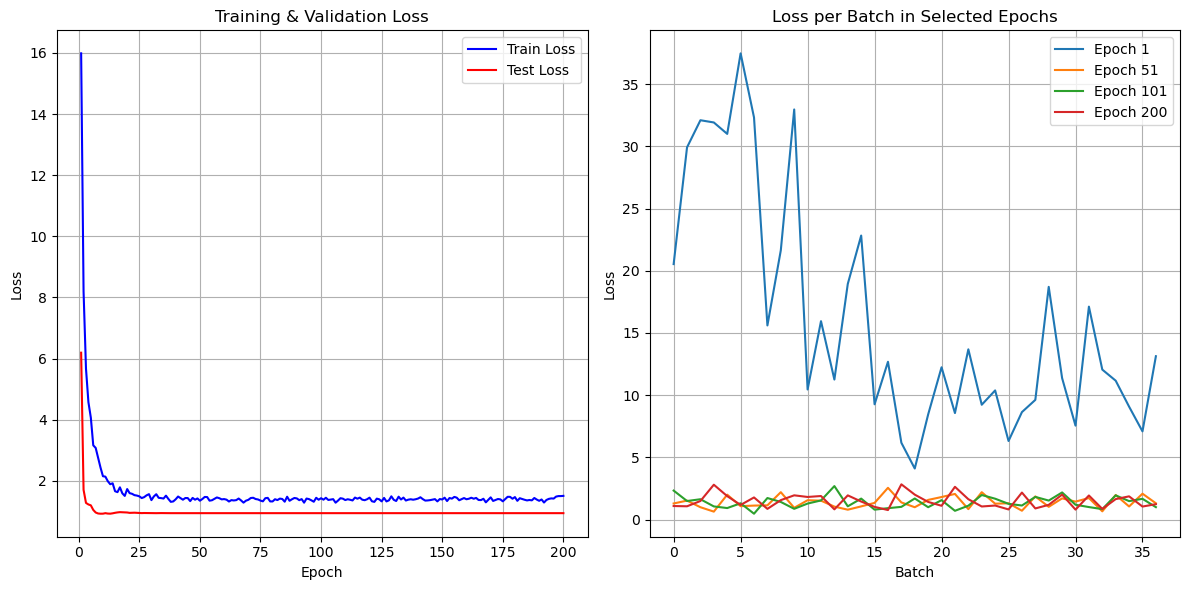

In [18]:
# Vẽ loss theo epoch
plt.figure(figsize=(12, 6))

# Vẽ Train & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch+1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, max_epoch+1), test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for epoch in [0, max_epoch//4, max_epoch//2, max_epoch-1]:  # Chọn vài epoch để hiển thị
    plt.plot(batch_losses[epoch], label=f"Epoch {epoch+1}")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss per Batch in Selected Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [20]:
torch.save(model, '../model/model.pth')

In [24]:
filepath = os.path.join('..','data', 'raw', 'test.csv')
data = pd.read_csv(filepath, index_col='Id')

# Loại bỏ cột cuối cùng khỏi danh sách cột xử lý
columns_to_process = data.columns

# Find columns with missing values
lst_of_missing = [col for col in columns_to_process if data[col].isnull().sum() > 0]

# Find numerical and categorical columns
lst_of_numerical = [col for col in columns_to_process if data[col].dtype != 'object']
lst_of_categorical = [col for col in columns_to_process if data[col].dtype == 'object']

# Print information about missing categorical columns
cat_missing = set(lst_of_categorical) & set(lst_of_missing)
print(f'There are {len(cat_missing)} categorical columns with missing values')
for col in cat_missing:
    print(f'{col:<13}: {data[col].isnull().sum(): <4} missing values - {data[col].isnull().sum() / len(data) * 100:.2f}% - {len(data[col].unique())} unique values')

# Save preprocessed data
output_dir = os.path.join('data', 'preprocessed')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'test_preprocessed.csv')
data.to_csv(output_filepath)
print(f"Preprocessed data saved to {output_filepath}")

There are 22 categorical columns with missing values
BsmtExposure : 44   missing values - 3.02% - 5 unique values
FireplaceQu  : 730  missing values - 50.03% - 6 unique values
Utilities    : 2    missing values - 0.14% - 2 unique values
MiscFeature  : 1408 missing values - 96.50% - 4 unique values
Fence        : 1169 missing values - 80.12% - 5 unique values
Exterior2nd  : 1    missing values - 0.07% - 16 unique values
GarageQual   : 78   missing values - 5.35% - 5 unique values
GarageType   : 76   missing values - 5.21% - 7 unique values
BsmtQual     : 44   missing values - 3.02% - 5 unique values
PoolQC       : 1456 missing values - 99.79% - 3 unique values
BsmtFinType1 : 42   missing values - 2.88% - 7 unique values
GarageCond   : 78   missing values - 5.35% - 6 unique values
MasVnrType   : 894  missing values - 61.27% - 4 unique values
KitchenQual  : 1    missing values - 0.07% - 5 unique values
GarageFinish : 78   missing values - 5.35% - 4 unique values
BsmtFinType2 : 42   missin

In [25]:
filepath = './data/preprocessed/test_preprocessed.csv'
data = pd.read_csv(filepath, index_col='Id')

# Fill missing values
data['LotFrontage'] = data['LotFrontage'].fillna(data[data['LotFrontage'] < 300]['LotFrontage'].mean())
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['GarageYrBlt'].interpolate())
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

# Fill missing values for categorical columns
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data.drop(['MiscFeature', 'PoolQC', 'Fence', 'Alley'], axis=1, inplace=True)

# Encode categorical columns
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store encoders for potential inverse transform

# Standardize numerical features
scaler = StandardScaler()
data_standardized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Save preprocessed data
output_filepath = './data/preprocessed/test_preprocessed.csv'
data_standardized.to_csv(output_filepath)
print(f"Preprocessed data saved to {output_filepath}")

Preprocessed data saved to ./data/preprocessed/test_preprocessed.csv


In [30]:
# Load preprocessed test data
test_filepath = '../data/preprocessed/test_preprocessed.csv'
test_data = pd.read_csv(test_filepath, index_col='Id')

test_tensor = torch.tensor(test_data.values, dtype=torch.float32)

# Load trained model
model_path = '../model/model.pth'
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()

# Perform inference
with torch.no_grad():
    test_tensor = test_tensor.to(device)
    predictions = model(test_tensor).cpu().numpy()

# Load scaling parameters
# Load scaling parameters safely
scaling_params_filepath = '../data/preprocessed/scaling_params.txt'

with open(scaling_params_filepath, 'r') as f:
    lines = f.readlines()
    mean = float(lines[0].split()[1])
    std = float(lines[1].split()[1])
        
# Reverse standardization
predictions = predictions * std + mean

# Giả sử `test_data` có index là Id
ids = test_data.index  # Lấy cột Id từ dữ liệu test ban đầu

# Tạo DataFrame với 2 cột: Id và SalesPrice
df_predictions = pd.DataFrame({'Id': ids, 'SalePrice': predictions.flatten()})

# Lưu file CSV
output_dir = './data/output'
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'predictions.csv')

df_predictions.to_csv(output_filepath, index=False)

print(f"Predictions saved to {output_filepath}")

Predictions saved to ./data/output\predictions.csv
